# Predictive modelling of player prices

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

In [11]:
# Import model data
path = 'file:///C:/Users/micha/Documents/Quant/football_index/model_data.csv'
df = pd.read_csv(path)
df.set_index('PlayerName', inplace=True)

# Gen X and y matrices/vectors, leaving out forward to avoid multicollinearity problems
y_col = 'CurrentPrice'
X_cols = ['ave_matchday_score',
          'Age',
          'num_games_played',
          'Midfielder',
          'Defender',
          'Goalkeeper']

# Slice off target vector
y = df[y_col]

# Generate polynomial features, and scale the feature matrix
X_df = df[X_cols]

poly = PolynomialFeatures(degree=2, include_bias=False)
poly_X = poly.fit_transform(X_df)

# Feature scaling since we are using regularisation
scaler = StandardScaler()
scaled_X = scaler.fit_transform(poly_X)

# Drop indicator variable squares and interactions
feature_names = poly.get_feature_names(X_cols)[:-6]
X = np.delete(scaled_X, slice(-6, None), axis=1)

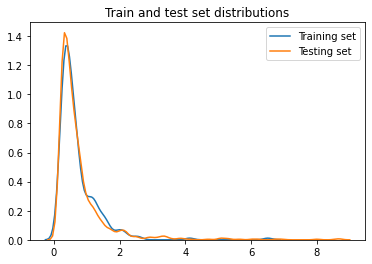

In [14]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42)

# Check stratification of train test since we have a skewed dataset and due to what 
# error metric we're using
fig, ax = plt.subplots()
ax.set_title('Train and test set distributions')
sns.kdeplot(y_test, label='Training set', ax=ax)
sns.kdeplot(y_train, label='Testing set', ax=ax)

# Model Building

Model 1: Benchmark linear regression

In [17]:
# Train vanilla model
lm = LinearRegression()
model_1 = lm.fit(X_train, y_train)
coeffs = model_1.coef_

np.mean(cross_val_score(lm, X_train, y_train, scoring='neg_mean_absolute_error'))

-0.35024912445630174

Since this is a vanilla linear model with scaled features, we can check feature importance to see if there is any dead weight.

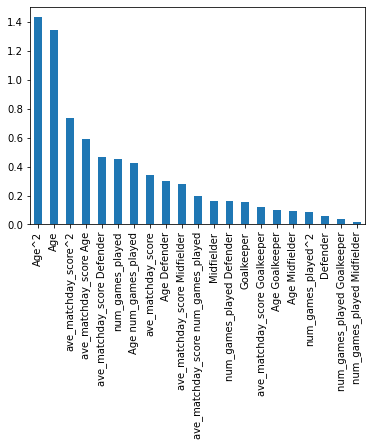

In [19]:
# Feature importance mapped out. Since we have scaling in the pipeline we can do this...
feature_importance = pd.Series(coeffs, index=feature_names).abs().sort_values(ascending=False)

# Plotting feature importance...
feature_importance.plot.bar()

Considering plot above we consider if lasso may help our original model by removing some unimportant features at the tail end here. More noise than signal.

In [25]:
# MODEL 2: LASSO

# Using non-stratified k-fold cv to find optimal alpha
lasso = Lasso()

# mae since we know we have outliers, we don't want to fit to these too much
lasso_grid = {'alpha': list(np.arange(0.005, 1, 0.005))}
model_2 = GridSearchCV(lasso, lasso_grid, scoring='neg_mean_absolute_error')

results = model.fit(X_train, y_train)

print(results.best_params_)
print(results.best_score_)

{'alpha': 0.005}
-0.3518986383151682


Clearly we dont have excessive model complexity here for our modest amount of training data
no regularisation is better than some, so we decide to try increasing model complexity

From the above, LASSO looks like it has some headroom, lets use a random forest to capture some more 
subtle non-linearities and interaction here.

Since we've seen that the polys are mostly useful features, we pass these directly to our random forest model so it can have them straight up, doesn't have to make them itself.

In [26]:
# First use default sklearn rf
rf = RandomForestRegressor(n_jobs=-1)
np.mean(cross_val_score(rf, X_train, y_train, scoring='neg_mean_absolute_error'))

-0.34594201208041664

Not much improvement, lets tune some hyperparams to see what we get.

First randomized search to narrow down options. 

In [28]:
# Narrow down your options
random_grid = {'max_depth': np.arange(5, 50),
               'min_samples_split': np.arange(2, 50),
               'max_leaf_nodes': np.arange(5, 100)}  # wide net

random_search = RandomizedSearchCV(rf, random_grid, 
                           scoring='neg_mean_absolute_error', random_state=42,
                           n_iter=25)
results_1 = random_search.fit(X_train, y_train)

print(results_1.best_params_)
print(results_1.best_score_)

{'min_samples_split': 13, 'max_leaf_nodes': 68, 'max_depth': 27}
-0.3469915068635177


Now we have some initial estimates we can try to narrow things down

In [31]:
# Final tune
param_grid = {'max_depth': np.arange(22, 33, 2),
               'min_samples_split': np.arange(8, 19, 2),
               'max_leaf_nodes': np.arange(63, 74, 2)}  # narrow net

grid_search = GridSearchCV(rf, param_grid, scoring='neg_mean_absolute_error')
results_2 = grid_search.fit(X_train, y_train)
print(results_2.best_params_)
print(results_2.best_score_)

{'max_depth': 28, 'max_leaf_nodes': 65, 'min_samples_split': 8}
-0.34500163465126654


We appear to have; without adding data or features, maxed out our models for this purpose. 
In the interest of occams protocol, and explicit > implicit; we decide our polynomial linreg is the best model. 

In [32]:
# Final results
final_model = LinearRegression().fit(X_train, y_train)

y_pred_test = model.predict(X_test)
mean_absolute_error(y_test, y_pred_test)

0.28332005619362893

Prefer lin reg model, as occams protocol and explicit better than implicit.
This actually generalises nicely as well.